In [17]:
import os
import pandas as pd
import pickle
import seaborn as sns

In [2]:
#!pip install plotly
#pd.options.plotting.backend = "plotly"

In [43]:
model_dirs = {'elasticnet': '../out/20.0819 modcompr/reg_elasticNet_infer/',
              'lm': '../out/20.0819 modcompr/reg_lm_infer/', 
              'rf': '../out/20.0819 modcompr/reg_rf_infer/', 
              'rf_boruta': '../out/20.0216 feat/reg_rf_boruta'
             }

## model results

In [171]:
scores = {}
for model, model_dir in model_dirs.items():
    res = pd.read_csv(os.path.join(model_dir, 'model_results.csv'))
    scores.update({model: res.loc[res.model=='all','score_test'].values})

scores = pd.DataFrame.from_dict(scores)

In [172]:
scores.median(axis=0)

elasticnet    0.106759
lm            0.046777
rf            0.081882
rf_boruta     0.081882
dtype: float64

[Text(0, 0.5, 'Score (on test)'),
 Text(0.5, 0, 'Models'),
 [Text(0, 0, 'elastic net'),
  Text(1, 0, 'linear regression'),
  Text(2, 0, 'random forest'),
  Text(3, 0, 'random forest\niter select+boruta')],
 Text(0.5, 1.0, 'Model using all features')]

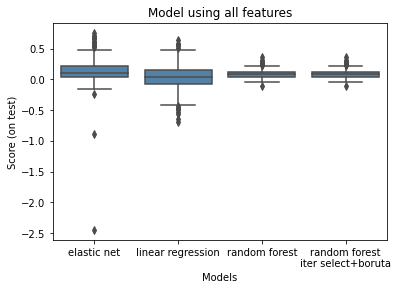

In [142]:
xlab_dict = {'elasticnet': 'elastic net',
              'lm': 'linear regression', 
              'rf': 'random forest', 
              'rf_boruta': 'random forest\niter select+boruta'}
df = pd.melt(scores)
ax = sns.boxplot(data=df, x='variable', y='value', color='steelblue')
ax.set(ylabel='Score (on test)', xlabel='Models', xticklabels=[xlab_dict[n] for n in model_dirs.keys()],
      title='Model using all features')

### train vs test for linear models

In [189]:
res = pd.read_csv(os.path.join(model_dirs['elasticnet'], 'model_results.csv'))
res.loc[res.model=='all',['score_train', 'score_test']].describe()

,score_train,score_test
count,583.000000,583.000000
mean,0.222645,0.137925
std,0.148122,0.187106
min,0.000000,-2.455304
25%,0.110866,0.036640
50%,0.186384,0.106759
75%,0.311160,0.221161
max,0.764792,0.761665


[Text(0, 0.5, 'Score'),
 Text(0.5, 0, ''),
 [Text(0, 0, 'Train'), Text(1, 0, 'Test')],
 Text(0.5, 1.0, 'Elastic net'),
 (-1.0, 1.2),

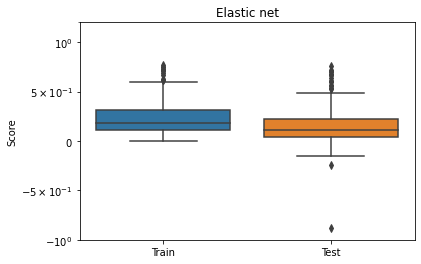

In [190]:
df = pd.melt(res.loc[res.model=='all',['score_train', 'score_test']])
ax = sns.boxplot(data=df, x='variable',y='value')
ax.set_yscale('symlog')
ax.set(ylabel='Score', xlabel='',xticklabels=['Train','Test'], title='Elastic net',
       ylim=[-1,1.2], yticks=[-1,-0.5,0,0.5,1])

In [191]:
res = pd.read_csv(os.path.join(model_dirs['lm'], 'model_results.csv'))
res.loc[res.model=='all',['score_train', 'score_test']].describe()

,score_train,score_test
count,583.0,583.000000
mean,1.0,0.030242
std,0.0,0.182642
min,1.0,-0.688894
25%,1.0,-0.076855
50%,1.0,0.046777
75%,1.0,0.149190
max,1.0,0.643561


[Text(0, 0.5, 'Score'),
 Text(0.5, 0, ''),
 [Text(0, 0, 'Train'), Text(1, 0, 'Test')],
 Text(0.5, 1.0, 'Linear regression'),
 (-1.0, 1.2),

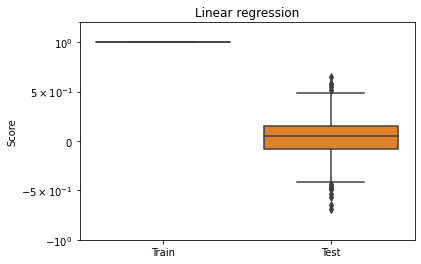

In [192]:
df = pd.melt(res.loc[res.model=='all',['score_train', 'score_test']])
ax = sns.boxplot(data=df, x='variable',y='value')
ax.set_yscale('symlog')
ax.set(ylabel='Score', xlabel='',xticklabels=['Train','Test'], title='Linear regression', 
       ylim=[-1,1.2], yticks=[-1,-0.5,0,0.5,1])

Although the linear models look ok, but they overfitted quite substantially. Next we'll look at the results after feature selection, so to minimize overfitting on these linear models (the random forests don't overfit so we'll directly look at the test scores).

## anlyz

aggRes stats_score aggregates the scores, without excluding negative scores

feat stats_score aggregates the scores, and excludes negative scores

In [162]:
scores_fl = {}
scores_rd = {}
scores_rd10 = {}
for model, model_dir in model_dirs.items():
    res = pd.read_csv(os.path.join(model_dir, 'anlyz/stats_score_aggRes/stats_score.csv'), index_col=0)
    scores_fl.update({model: res.loc[res.index=='50%', 'full'].values})
    scores_rd.update({model: res.loc[res.index=='50%', 'reduced'].values})
    scores_rd10.update({model: res.loc[res.index=='50%', 'reduced10feat'].values})

scores_fl = pd.DataFrame.from_dict(scores_fl)
scores_rd = pd.DataFrame.from_dict(scores_rd)
scores_rd10 = pd.DataFrame.from_dict(scores_rd10)

In [163]:
df = pd.concat([scores_fl, 
           scores_rd,
           scores_rd10], axis=0)
df = df.T
df.columns = ['full', 'reduced', 'reduced_top10feat']
df

,full,reduced,reduced_top10feat
elasticnet,0.10711,0.10711,0.10011
lm,0.04678,0.05312,-0.02417
rf,0.08188,0.10336,0.25855
rf_boruta,0.08188,0.34822,0.38289


[Text(0, 0.5, 'Score (median)'),
 Text(0.5, 0, 'Model'),
 [Text(0, 0, 'elastic net'),
  Text(1, 0, 'linear regression'),
  Text(2, 0, 'random forest'),
  Text(3, 0, 'random forest\niter select+boruta')],
 Text(0.5, 1.0, 'Reduced model with top 10 features')]

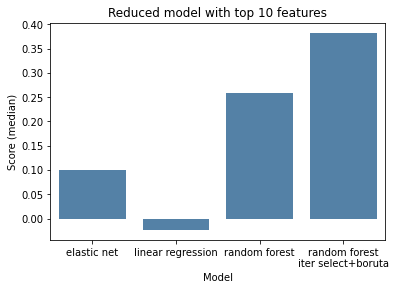

In [170]:
xlab_dict = {'elasticnet': 'elastic net',
              'lm': 'linear regression', 
              'rf': 'random forest', 
              'rf_boruta': 'random forest\niter select+boruta'}
ax = sns.barplot(scores_rd10.columns, scores_rd10.values[0], color='steelblue')
ax.set(ylabel='Score (median)', xlabel='Model',xticklabels=[xlab_dict[n] for n in model_dirs.keys()],
       title='Reduced model with top 10 features')

## anlyz_filtered

In [12]:
scores_fl = {}
scores_rd = {}
scores_rd10 = {}
for model, model_dir in model_dirs.items():
    res = pd.read_csv(os.path.join(model_dir, 'anlyz_filtered/stats_score_aggRes/stats_score.csv'), index_col=0)
    scores_fl.update({model: res.loc[res.index=='mean', 'full'].values})
    scores_rd.update({model: res.loc[res.index=='mean', 'reduced'].values})
    scores_rd10.update({model: res.loc[res.index=='mean', 'reduced10feat'].values})

scores_fl = pd.DataFrame.from_dict(scores_fl)
scores_rd = pd.DataFrame.from_dict(scores_rd)
scores_rd10 = pd.DataFrame.from_dict(scores_rd10)

In [13]:
df = pd.concat([scores_fl.mean(), 
           scores_rd.mean(),
           scores_rd10.mean()], axis=1)
df.columns = ['full', 'reduced', 'reduced_top10feat']
df

,full,reduced,reduced_top10feat
elasticNet,0.251047,0.251049,0.247983
lm,0.066277,0.074152,0.454841
rf,0.098717,0.132054,0.379765
rf_boruta,0.090035,0.382149,0.424561


Better to use anlyz, as anlyz_filtered applies filtering to the results, and the final list would be different among the different models